## Final Project: Reaction wheel inverted pendulum

`./docker_run_notebook.sh drake-20190423 .`

---

# LQR Analysis 

In this question we'll use a classic underactuated system, the inertial wheel pendulum, to do a case study in bringing together all of these components:

- Stabilization at the upright position using LQR (and how to linearize around a fixed point)
- Finding where is our LQR controller "good", i.e. computing the region of attraction (RoA)
- Swinging up with a simple energy-shaping controller and switching to LQR when inside the RoA

An inertial wheel pendulum is a single-link pendulum with a torque-controlled reaction wheel mounted at its end:

<p align="center">
  <img src="./iwp.png" width="350"/>
</p>

*(Image source Ramirez-Neria, Mario, et al. "On the linear Active Disturbance Rejection Control of the inertia wheel pendulum.")*

The angle of the pendulum is $\theta_1$, and the angle of the reaction wheel is $\theta_2$. The only control input is a (bounded) torque applied to the wheel, $\tau$
$$
{x} = \left[ \begin{array}{c} q
\\ \dot q 
\end{array} \right]
\ \ \ \ \
{q} = \left[ \begin{array}{c}
\theta_1 \\
\theta_2 \end{array} \right]
\ \ \ \ \
{u} = \left[ \tau \right]
\ \ \ \ \
|\tau| \leq \tau_{max}
$$


---

Filling in the manipulator equations for our single-link pendulum,

$$
M \ddot{q} + C(q, \dot{q})\dot{q} = \tau_g(q) + Bu \\
M = \left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right]
\ \ \ \ \ 
C = \left[
\begin{array}{c c}
 0 & 0 \\
 0 & 0
\end{array}
\right]\\
\tau_g(q) = \left[
\begin{array}{c}
 -(m_1 l_1 + m_2 l_2) g sin(\theta_1) \\ 0
\end{array}
\right]
\ \ \ \ \ 
B = \left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right]
$$

$\tau_g(q)$ should look familiar from the simple pendulum case. The effect of $M$ is little trickier, as it includes some interaction terms between $\theta_1$ and $\theta_2$. [This textbook's](http://home.deib.polimi.it/gini/robot/docs/spong.pdf) treatment of the double pendulum (which has fundamentally similar inertia) in Chapter 9 might be of use if you want to dig into this more thoroughly.  

---

## 3.1 Linearization (4 points, 4/4 autograded)

We're interested in stabilizing this system to its upright fixed point at $\theta_1 = \pi$. Let's try using LQR to do this. As a first step, calculate the linearization of these dynamics -- that is, find functions $A(x_f)$ and $B(x_f)$ such that the linear system $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$, for $\bar{x} = x-x_f$ and $\bar{u} = u-u_f$, approximates our full system in the neighborhood of the fixed point $x_f, u_f$. **Derive those here, and also fill out the corresponding function $GetLinearizedDynamics$ of *inertial_wheel_pendulum.py* to generate these.**


Plug into  $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \dot{\theta_2} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 0 & 1 & 0 \\ 
 0 & 0 & 0 & 1 \\ 
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}  & 0 & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \theta_2 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

In [9]:
# These IPython-specific commands
# tell the notebook to reload imported
# files every time you rerun code. So
# you can modify inertial_wheel_pendulum.py
# and then rerun this cell to see the changes.
%load_ext autoreload
%autoreload 2

from inertial_wheel_pendulum import *
import math
import numpy as np
# Make numpy printing prettier
np.set_printoptions(precision=3, suppress=True)

# Define the upright fixed point here.
uf = np.array([0.])
xf = np.array([math.pi, 0, 0, 0])
#xf = np.array([0, 0, 0, 0])

# Units: kg, m, sec
# Radians
# THIS IS NOT MEASURED
'''
m1 = 1. # Pendulum 
l1 = 1. # 

m2 = 2. # Reaction wheel 
l2 = 2. # 
r = 1.0 # 

g = 9.8  # Default 10

'''

m1 = (0.140) + 0.240
l1 = 0.21
m2 = 0.138
l2 = 2 * l1
r = 0.0572/2


const = 1
m1 = const * m1
l1 = const * l1
m2 = const * m2
l2 = const * l2
r = const * r


input_max = 10 # 
pendulum_plant = InertialWheelPendulum(
    m1 = m1, l1 = l1, m2 = m2, l2 = l2, 
    r = r, g = g, input_max = input_max)

'''
FROM CALCULATIONS IN EXTERNAL FILE
Defined in `inertial_wheel_pendulum.py`
'''
A, B = pendulum_plant.GetLinearizedDynamics(uf, xf)
print("A: ", A)
print("B: ", B)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
h2i
('A: ', array([[  0.   ,   0.   ,   1.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   1.   ],
       [ 23.333,   0.   ,   0.   ,   0.   ],
       [-23.333,   0.   ,   0.   ,   0.   ]]))
('B: ', array([[     0.   ],
       [     0.   ],
       [   -17.283],
       [ 17735.452]]))


## 3.3 LQR (4 points, 4/4 autograded)

Now that we have a linear system to control, let's try employing LQR to balance the inertial pendulum. Recalling LQR as discussed in class, you need to supply LQR with a couple things:

- Linear system matrices $A$ and $B$
- Symmetric positive semi-definite state cost matrix $Q$
- Symmetric positive definitive input cost matrix $R$
- Another cost matrix $N$ for the off-diagonal terms. (For most of our problems, this is set to zero.)

And it produces an optimal gain matrix $K$ for the optimal controller $\bar{u} = - K\bar{x}$ that minimizes

$$\min_u \int_0^\infty \bar{x}'Q\bar{x} + \bar{u}'R\bar{u} + 2\bar{x}'N\bar{u} dt $$

LQR also returns the cost-to-go matrix $S$, with the optimal cost-to-go taking the form $J(x) = \bar{x}^T S \bar{x}$.

In this problem, we have a complication: we probably don't want to try to control the reaction wheel angle $\theta_2$, as it has no impact on our dynamics. (Check the dynamics as derived above to see this yourself!) Your first instinct might be to set the 2nd row and column of $Q$ to zero: but unfortunately, this doesn't work, as exemplified below.

In this case, the solution is underdetermined (the algebraic Riccati equation no longer has a *unique* solution, but instead an infinite number of equally-good ones). Instead, because $\theta_2$ never appears in the dynamics, you can form a modified linear system to give to LQR:

$$\dot{x}_{reduced} = A_{reduced}x_{reduced} + B_{reduced}u_{reduced}$$

where $x_{reduced} = \left[\theta_1, \dot \theta_1, \dot \theta_2 \right]^T$, and insert zeros approximately to bring your final $K$ and $S$ back up to $1 \times 4$ and $4 \times 4$ matrices. 

**Do this state reduction, pick reasonable Q and R matrices, invoke LQR, and reverse your state reduction to generate K and S matrices.**

# Basically all we are doing is dropping the column we're not interested in and putting it back in after ward (wow what unnecessarily fancy words...)

Previously had  $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \dot{\theta_2} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 0 & 1 & 0 \\ 
 0 & 0 & 0 & 1 \\ 
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}  & 0 & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \theta_2 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

Now with x reduced:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 1 & 0 \\  
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

In [10]:
from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         LinearQuadraticRegulator, RigidBodyPlant,
                         RigidBodyTree, Simulator)

def create_reduced_lqr(A, B):
    '''
    Code submission for 3.3: Fill in the missing
    details of this function to produce a control
    matrix K, and cost-to-go matrix S, for the full
    (4-state) system.
    '''
    
    idx_removed = 1
    A_reduced = np.delete(A, idx_removed, axis=0)
    A_reduced = np.delete(A_reduced, idx_removed, axis=1)
    
    B_reduced = np.delete(B, idx_removed)
    
        
    # We care about theta1 the most, then theta1dot, theta2dot 
    
    Q_reduced = np.diag([10., 1, 0.1])
    R_reduced = [0.1] # we only have one output
    
    K_reduced, S_reduced = LinearQuadraticRegulator(A_reduced, B_reduced, 
                                                    Q_reduced, R_reduced)
    
    # Add 0s back to back deleted column and row
    K = np.insert(K_reduced, idx_removed, 0)
    K = K.reshape((1,4))
    
    S = np.insert(S_reduced, idx_removed, 0, axis=0)
    S = np.insert(S, idx_removed, 0, axis=1)
    
    
    return (K, S)

K, S = create_reduced_lqr(A, B)
print "K: ", K
print "S: ", S

K:  [[-9911.523     0.    -2052.882    -1.   ]]
S:  [[ 1017361.472        0.      210715.674      205.288]
 [       0.           0.           0.           0.   ]
 [  210715.674        0.       43643.53        42.519]
 [     205.288        0.          42.519        0.041]]


# TODO: The full (energy shaping) controller. 
# In the meantime, let's just implement LQR and start it around the fixed point!

**Finally, use this controller to stabilize the robot in simulation!**

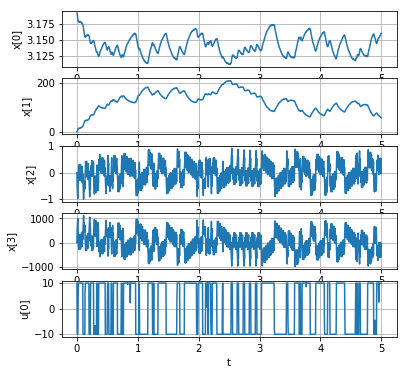

In [11]:
from inertial_wheel_pendulum import *
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *
import matplotlib.pyplot as plt

def lqr_controller(x):
    # This should return a 1x1 u that is bounded
    # between -input_max and input_max.
    # Remember to wrap the angular values back to
    # [-pi, pi].
    #print x
    global xf, uf, K
    
    #x[1] = (x[1])%(math.pi*2)
    #x[2] = (x[2])%(math.pi*2)
    #print x- xf
    #print xf
    u = np.zeros((1, 1))
    error = x-xf;
    error[1] = (error[1])%(math.pi*2)
    if(error[1]>math.pi):
        error[1] = error[1]-2*math.pi
    
    error[0] = (error[0])%(math.pi*2)
    if(error[0]>math.pi):
        error[0] = error[0]-2*math.pi
    
    #print error
    
    ideal_control = -np.dot(K,error)
    
    if(ideal_control< -input_max ):
        u=np.array([-input_max])
    elif(ideal_control>input_max):
        u=np.array([input_max])
    else:
        u=ideal_control
    
    ''' 
    Code submission for 3.3: fill in the code below
    to use your computed LQR controller (i.e. gain matrix
    K) to stabilize the robot by setting u appropriately.
    '''
    
    # u = 0
    return u

# Run forward simulation from the specified initial condition
duration = 5.

########################### START STATE
x0 = [3.192,0.0,0.0,0.0]
#x0 = [3.14,0.0,0.0,0.0]
#x0 = [3, 0.0, 0.0, 5.0]
input_log, state_log = \
    RunSimulation(pendulum_plant,
              lqr_controller,
              x0=x0,
              duration=duration)

    
# Visualize state and input traces
fig = plt.figure().set_size_inches(6, 6)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

# Visualize the simulation
viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

# NOT DONE

In [12]:
# The swingup controller should accept a state x,
# and return a control input u (a 1x1 numpy array)
# that respects the plant's input limits.
def swingup_controller(x):
    # Here's some useful things...
    q = x[0:2]
    qf = xf[0:2]
    qd = x[2:4]
    (M, C, tauG, B) = pendulum_plant.GetManipulatorDynamics(q, qd)
    k=10
    
    ''' 
    Code response for problem 3.8:
    Fill in this swingup controller to control the pendulum
    energy to the homonclinic orbit.
    (You'll probably want to ensure that your controller
    controls the velocity of the inertial wheel, too, using whatever
    means you think are reasonable.)
    '''
    #get the difference in current energy and desired energy at stable point at top
    Ecurr = .5*qd[0]*M[0,0]*qd[0]+pendulum_plant.GetPE(q, qd);
    Emax = pendulum_plant.GetPE(qf, qd);
    Etilde = Ecurr-Emax;
    
    u = np.array([0.])
   
    if(Etilde < Emax/2 and abs(qd[0]) <0.1):
        #if stuck at a difficult to control point with low energy, just spin the wheel at max to get somewhere else
        ideal_control = input_max;
        #print "ahhh"
    elif(qd[1]>50): #if wheel is spinning too fast slow it down
        ideal_control = -input_max;
    elif (qd[1]<-50):#if wheel is spinning too fast slow it down
        ideal_control = input_max;
    else:
        #if in a reasonable spot to control, implement the derived control
        ideal_control = (2*tauG[0]/ M[0,1])+k*qd[0]*Etilde; 
    
    #make sure the control is not outside of the feasible range
    if(ideal_control< -input_max ):
        u=np.array([-input_max])
    elif(ideal_control>input_max):
        u=np.array([input_max])
    else:
        u=ideal_control
    return u

def combined_controller(x):
    ''' 
    Code response for problem 3.8:
    Fill in this combined controller to dispatch to either the
    swingup or lqr controller by checking the state against your
    calculated region of attraction.
    '''
    global rho
    u = np.array([0.])
    #print rho
    #print calcV(x)
    
    if calcV(x) < rho:
        #check if in an LQR-controllable state
        #print "in lqr!"
        u[0] = lqr_controller(x)
    else:
        u[0] = swingup_controller(x)
    
    return u

# Simulate!
x0 = [2.0, 0.0, -0.5, 100.]
#x0 = [0.0, 0.0, 0.0, 0.0]
duration = 30
input_log, state_log = RunSimulation(pendulum_plant,
                        combined_controller,
                        x0 = x0,
                        duration = duration)

# Plot traces of the results
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12,12)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

NameError: global name 'calcV' is not defined

In [ ]:
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *

viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

In [ ]:
import os
# Run the test in a subprocess, to make sure it doesn't open any plots...
os.popen("python test_set_3.py ./ test_results.json")

# Print the results json for review
import test_set_3
print test_set_3.pretty_format_json_results("test_results.json")